Data section

Connecticut counties

Let's download all the dependencies that we will need

In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import numpy as np # library to handle data in a vectorized manner

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

Loading and exploring the data of Connecticut counties

In [2]:
!wget -q -O 'countyct_37800_0000_2010_s100_census_1_t.csv'  http://magic.lib.uconn.edu/magic_2/vector/37800/countyct_37800_0000_2010_s100_census_1_t.csv
df_c = pd.read_csv('countyct_37800_0000_2010_s100_census_1_t.csv')

print('Data downloaded!')

Data downloaded!


In [3]:
df_c.head()

,FID_,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,CBSAFP10,METDIVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geo_id_ff2,GeoID_AFF1
0,NaN,9,1,212794,9001,Fairfield,Fairfield County,6,H4,G4020,408,14860,,N,1.618456e+09,549162331.0,41.228103,-73.366757,0500000US09001\r\n0500000US09001,05000US09001
1,NaN,9,11,212799,9011,New London,New London County,6,H4,G4020,,35980,,N,1.722026e+09,276665774.0,41.478630,-72.103452,0500000US09011,05000US09011
2,NaN,9,5,212796,9005,Litchfield,Litchfield County,6,H4,G4020,408,45860,,N,2.384239e+09,62165569.0,41.791897,-73.235428,0500000US09005,05000US09005
3,NaN,9,15,212801,9015,Windham,Windham County,6,H4,G4020,278,48740,,N,1.328430e+09,22092290.0,41.824999,-71.990702,0500000US09015,05000US09015
4,NaN,9,13,212668,9013,Tolland,Tolland County,6,H4,G4020,278,25540,,N,1.062448e+09,17698315.0,41.858076,-72.340977,0500000US09013,05000US09013


Removing columns to keep only the relevant ones for my research

In [4]:
df_c.drop(["FID_", "STATEFP10", "COUNTYFP10", "COUNTYNS10", "GEOID10", "NAMELSAD10", "LSAD10", "CLASSFP10", "MTFCC10", "CSAFP10", "CBSAFP10", "METDIVFP10", "FUNCSTAT10", "ALAND10", "AWATER10", "geo_id_ff2", "GeoID_AFF1"], axis=1, inplace=True)
df_c

,NAME10,INTPTLAT10,INTPTLON10
0,Fairfield,41.228103,-73.366757
1,New London,41.478630,-72.103452
2,Litchfield,41.791897,-73.235428
3,Windham,41.824999,-71.990702
4,Tolland,41.858076,-72.340977
5,Hartford,41.806053,-72.732916
6,Middlesex,41.434525,-72.524227
7,New Haven,41.349717,-72.900204


In [5]:
df_c.rename(columns={'NAME10':'Neighborhood'}, inplace=True)
df_c.rename(columns={'INTPTLAT10':'Latitude'}, inplace=True)
df_c.rename(columns={'INTPTLON10':'Longitude'}, inplace=True)
df_c

,Neighborhood,Latitude,Longitude
0,Fairfield,41.228103,-73.366757
1,New London,41.478630,-72.103452
2,Litchfield,41.791897,-73.235428
3,Windham,41.824999,-71.990702
4,Tolland,41.858076,-72.340977
5,Hartford,41.806053,-72.732916
6,Middlesex,41.434525,-72.524227
7,New Haven,41.349717,-72.900204


In [6]:
print('The dataframe has {} neighborhood.'.format(
        len(df_c['Neighborhood'].unique()),
        df_c.shape[0]
    )
)

The dataframe has 8 neighborhood.


In [7]:
address = 'Connecticut, ON'

geolocator = Nominatim(user_agent="Connecticut")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Connecticut are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Connecticut are 41.51186235, -72.2493707784102.


Let's visualize the counties of Connecticut

In [8]:
# create map of Connecticut using latitude and longitude values
map_c = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, label in zip(df_c['Latitude'], df_c['Longitude'], df_c['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_c)  
    
map_c

Demographic data of population with Italian ancestry 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Resource: "http://www.niaf.org/culture/statistics/italian-american-populations-in-select-u-s-counties/"

Creating a Dataframe to show the clean data for Connecticut

In [10]:
from pandas import DataFrame

Connecticut = {'County': ['Hartford','New Haven','Fairfield','Litchfield', 'Middlesex', 'New London', 'Tolland','Windham'],
        'Amount': [134.654,201.069,159.785,39.477,32.858,35.489,21.022,10.010],
        'Percentage': [15.7,24.4,18.1,21.7,21.2,13.7,15.4,9.2]
        }

df_5 = DataFrame(Connecticut,columns= ['County', 'Amount', 'Percentage'])

print (df_5)

       County   Amount  Percentage
0    Hartford  134.654        15.7
1   New Haven  201.069        24.4
2   Fairfield  159.785        18.1
3  Litchfield   39.477        21.7
4   Middlesex   32.858        21.2
5  New London   35.489        13.7
6     Tolland   21.022        15.4
7     Windham   10.010         9.2


In [11]:
df_5 = df_5.set_index("County")

I have chosen the two counties of Connecticut (New Haven and Fairfield) that has the most Italian-American population and I have visualized data on a bar chart.

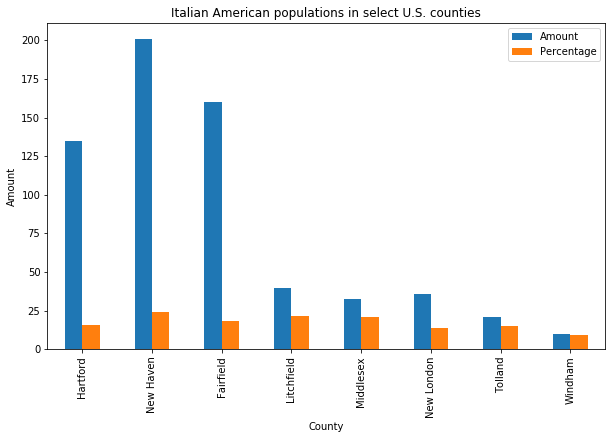

In [12]:
# plot data
df_5.plot(kind='bar', figsize=(10, 6))
 
plt.xlabel('County') # add to x-label to the plot
plt.ylabel('Amount') # add y-label to the plot
plt.title('Italian American populations in select U.S. counties') # add title to the plot
 
plt.show()

Foursquare location data of Italian restaurants as well as other venues such as, cinemas, theaters, and markets etc. of Connecticut for these two counties.

In [13]:
df_1 = df_c[df_c['Neighborhood'].isin(['Fairfield', 'New Haven'])]
df_1

,Neighborhood,Latitude,Longitude
0,Fairfield,41.228103,-73.366757
7,New Haven,41.349717,-72.900204


Defining Foursquare Credentials and Version

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
address = 'Connecticut, CT'

geolocator = Nominatim(user_agent="Connecticut")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Connecticut are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Connecticut are 41.6500201, -72.7342163.


Defining URL

In [16]:

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 10000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=2KWN44FD2WPPZXOKDTKHF1H4LHBCUVLDVMJXEN2QBRLBXBBM&client_secret=PEL12DGKOUDTBWT5I1IS33PWILNI11ZEJS1KJED2USK5ADFF&v=20180605&ll=41.6500201,-72.7342163&radius=10000&limit=100'

Sending the GET Request and examining the results

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d7c2b22a30619002cc4a1ce'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Newington',
  'headerFullLocation': 'Newington',
  'headerLocationGranularity': 'city',
  'totalResults': 232,
  'suggestedBounds': {'ne': {'lat': 41.74002019000009,
    'lng': -72.61399432065849},
   'sw': {'lat': 41.56002000999991, 'lng': -72.85443827934151}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4a568cf964a520698426e3',
       'name': "Stew Leonard's",
       'location': {'address': '3475 Berlin Tpke',
        'lat': 41.65200764766504,
        'lng': -72.72941590856229,
        'labeledLatLngs': [{'label': 'display'

Getting relevant part of JSON and transforming it into a pandas dataframe

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Cleaning the json and structure it into a pandas dataframe

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Stew Leonard's,Supermarket,41.652008,-72.729416
1,Sam's Club,Warehouse Store,41.651965,-72.732325
2,Starbucks,Coffee Shop,41.649981,-72.729335
3,Panera Bread,Bakery,41.664003,-72.720216
4,Alvarium Beer Company,Brewery,41.664172,-72.754806


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Exploring Neighborhoods in Connecticut

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Writing the code to run the above function on each neighborhood and create a new dataframe called ct_venues.

In [22]:
ct_venues = getNearbyVenues(names=df_1['Neighborhood'],
                                   latitudes=df_1['Latitude'],
                                   longitudes=df_1['Longitude']
                                  )

Fairfield
New Haven


Let's check how many venues were returned for each neighborhood

In [23]:
ct_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Fairfield,100,100,100,100,100,100
New Haven,100,100,100,100,100,100


Let's find out how many unique categories can be curated from all the returned venues

In [24]:
print('There are {} uniques categories.'.format(len(ct_venues['Venue Category'].unique())))

There are 90 uniques categories.


In [25]:
# create map of Connecticut venues using latitude and longitude values
map_venues = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map that represent the venues
for lat, lng, label in zip(ct_venues['Venue Latitude'], ct_venues['Venue Longitude'], ct_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues)  
    
map_venues

Let's narrow down the venues to the Italian Restaurants in New Haven and Fairfield. 

In [26]:
address = 'Connecticut, CT'

geolocator = Nominatim(user_agent="Connecticut")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Connecticut are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Connecticut are 41.6500201, -72.7342163.


In [27]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 10000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=Italian Restaurant'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=2KWN44FD2WPPZXOKDTKHF1H4LHBCUVLDVMJXEN2QBRLBXBBM&client_secret=PEL12DGKOUDTBWT5I1IS33PWILNI11ZEJS1KJED2USK5ADFF&v=20180605&ll=41.6500201,-72.7342163&radius=10000&limit=100&query=Italian Restaurant'

In [28]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d7c2b3bc58ed7002c496021'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Newington',
  'headerFullLocation': 'Newington',
  'headerLocationGranularity': 'city',
  'query': 'italian restaurant',
  'totalResults': 43,
  'suggestedBounds': {'ne': {'lat': 41.74002019000009,
    'lng': -72.61399432065849},
   'sw': {'lat': 41.56002000999991, 'lng': -72.85443827934151}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b6ccd51f964a5207a552ce3',
       'name': "Joey Garlic's",
       'location': {'address': '150 Kitts Ln',
        'lat': 41.68275647991802,
        'lng': -72.70916216331779,
        'labeledLat

In [29]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Joey Garlic's,Italian Restaurant,41.682756,-72.709162
1,Portofino's Restaurant,Italian Restaurant,41.642000,-72.770295
2,Bertucci's,Italian Restaurant,41.668760,-72.718839
3,"Michel Angelo's Pizzeria, Restaurant & Lounge",Italian Restaurant,41.647823,-72.679604
4,Elizabeth's Bar & Restaurant,Italian Restaurant,41.648167,-72.679494


In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=Italian Restaurant'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
it_venues = getNearbyVenues(names=df_1['Neighborhood'],
                                   latitudes=df_1['Latitude'],
                                   longitudes=df_1['Longitude']
                                  )

Fairfield
New Haven


In [106]:
print(it_venues.shape)
it_venues.head()

(77, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fairfield,41.228103,-73.366757,Bianco Rosso,41.191894,-73.430822,Italian Restaurant
1,Fairfield,41.228103,-73.366757,Portofino Restaurant & Bar,41.195179,-73.432256,Italian Restaurant
2,Fairfield,41.228103,-73.366757,John's Best Pizza,41.160774,-73.419374,Italian Restaurant
3,Fairfield,41.228103,-73.366757,Arezzo Ristorante,41.140502,-73.363962,Italian Restaurant
4,Fairfield,41.228103,-73.366757,Finalmente Trattoria,41.141648,-73.359106,Italian Restaurant


In [34]:
it_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Fairfield,15,15,15,15,15,15
New Haven,62,62,62,62,62,62


As New Haven has significantly higher number of Italian restaurants than Fairfield, let's perform K-means clustering on New Haven.

Import the libraries necessary for web scraping the data on New Haven's neighborhoods.

In [35]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://github.com/CT-Data-Haven/nhv2016/blob/487ebd54288008f3ecd48a80a2303c136ba68894/public/data/2016_nhv_display.csv")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df_n = pd.read_html(str(table))
print(df_n[0].to_json(orient='records'))

[{"Unnamed: 0":null,"Name":"Amity","Total population":4970,"Population under age 18":1327,"Percent under age 18":0.267,"Population ages 65+":479,"Percent ages 65+":0.096,"Latino population":669,"Percent Latino":0.135,"White population":1090,"Percent white":0.219,"Black population":2716,"Percent black":0.546,"Other race population":495,"Percent other race":0.1,"Total households":1830,"Owner-occupied households":839,"Homeownership rate":0.458,"Poverty status known":4970,"Population in poverty":1033,"Poverty rate":0.208,"Low-income population":2140,"Low-income rate":0.431,"High-income population":1067,"High-income rate":0.215,"Foreign-born population":631,"Percent foreign-born":0.127,"Under 18, poverty status known":1327,"Children in poverty":397,"Child poverty rate":0.299,"Low-income children":709,"Child low-income rate":0.534,"Ages 65+, poverty status known":479,"Seniors in poverty":112,"Senior poverty rate":0.234,"Low-income seniors":215,"Senior low-income rate":0.449},{"Unnamed: 0":nu

Creating a dataframe and processing the data

In [36]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://github.com/CT-Data-Haven/nhv2016/blob/487ebd54288008f3ecd48a80a2303c136ba68894/public/data/2016_nhv_display.csv")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df_n = pd.read_html(str(table))[0]
Neighborhood = df_n["Name"].tolist()

In [37]:
df_n.head()

,Unnamed: 0,Name,Total population,Population under age 18,Percent under age 18,Population ages 65+,Percent ages 65+,Latino population,Percent Latino,White population,Percent white,Black population,Percent black,Other race population,Percent other race,Total households,Owner-occupied households,Homeownership rate,Poverty status known,Population in poverty,Poverty rate,Low-income population,Low-income rate,High-income population,High-income rate,Foreign-born population,Percent foreign-born,"Under 18, poverty status known",Children in poverty,Child poverty rate,Low-income children,Child low-income rate,"Ages 65+, poverty status known",Seniors in poverty,Senior poverty rate,Low-income seniors,Senior low-income rate
0,NaN,Amity,4970,1327,0.267,479,0.096,669,0.135,1090,0.219,2716,0.546,495,0.100,1830,839,0.458,4970,1033,0.208,2140,0.431,1067,0.215,631,0.127,1327,397,0.299,709,0.534,479,112,0.234,215,0.449
1,NaN,Annex,6677,1557,0.233,692,0.104,3073,0.460,1915,0.287,1401,0.210,288,0.043,2432,896,0.368,6610,1728,0.261,2984,0.451,914,0.138,1627,0.244,1490,635,0.426,985,0.661,692,171,0.247,303,0.438
2,NaN,Beaver Hills,5135,1443,0.281,580,0.113,724,0.141,750,0.146,3374,0.657,287,0.056,2012,916,0.455,5135,969,0.189,2277,0.443,1088,0.239,399,0.087,1232,252,0.205,650,0.528,538,56,0.104,118,0.219
3,NaN,Dixwell,4962,1034,0.208,610,0.123,658,0.133,794,0.160,3272,0.659,238,0.048,1808,288,0.159,4145,1264,0.305,2348,0.566,526,0.127,368,0.074,1027,501,0.488,882,0.859,585,83,0.142,333,0.569
4,NaN,Downtown,10935,378,0.035,551,0.050,1209,0.111,6134,0.561,1216,0.111,2376,0.217,4342,408,0.094,6848,1518,0.222,2488,0.363,2110,0.306,2500,0.227,354,124,0.350,137,0.387,542,52,0.096,210,0.388


In [107]:
df_n.drop(["Unnamed: 0", "Total population", "Population under age 18", "Percent under age 18", "Population ages 65+", "Percent ages 65+", "Latino population", "Percent Latino", "White population", "Percent white", "Black population", "Percent black", "Other race population", "Percent other race", "Total households", "Owner-occupied households", "Homeownership rate", "Poverty status known", "Population in poverty", "Poverty rate", "Low-income population", "Low-income rate", "High-income population", "High-income rate", "Foreign-born population", "Percent foreign-born", "Under 18, poverty status known", "Children in poverty", "Child poverty rate", "Low-income children", "Child low-income rate", "Ages 65+, poverty status known", "Seniors in poverty", "Senior poverty rate", "Low-income seniors", "Senior low-income rate"], axis=1, inplace=True)
df_n.head()

,Name,State,Neighborhood
0,Amity,CT,"Amity,CT"
1,Annex,CT,"Annex,CT"
2,Beaver Hills,CT,"Beaver Hills,CT"
3,Dixwell,CT,"Dixwell,CT"
4,Downtown,CT,"Downtown,CT"


In [39]:
df_n['State'] = 'CT'
df_n.head()

,Name,State
0,Amity,CT
1,Annex,CT
2,Beaver Hills,CT
3,Dixwell,CT
4,Downtown,CT


In [40]:
df_n['Neighborhood'] = df_n['Name'] +','+ df_n['State']
df_n.head()

,Name,State,Neighborhood
0,Amity,CT,"Amity,CT"
1,Annex,CT,"Annex,CT"
2,Beaver Hills,CT,"Beaver Hills,CT"
3,Dixwell,CT,"Dixwell,CT"
4,Downtown,CT,"Downtown,CT"


In [41]:
df_nh=df_n.drop(['State'], axis=1)
df_nh.head()

,Name,Neighborhood
0,Amity,"Amity,CT"
1,Annex,"Annex,CT"
2,Beaver Hills,"Beaver Hills,CT"
3,Dixwell,"Dixwell,CT"
4,Downtown,"Downtown,CT"


In [42]:
df_nh2=df_nh.drop(df_nh.index[[19,20,21]])
df_nh2

,Name,Neighborhood
0,Amity,"Amity,CT"
1,Annex,"Annex,CT"
2,Beaver Hills,"Beaver Hills,CT"
3,Dixwell,"Dixwell,CT"
4,Downtown,"Downtown,CT"
5,Dwight,"Dwight,CT"
6,East Rock,"East Rock,CT"
7,East Shore,"East Shore,CT"
8,Edgewood,"Edgewood,CT"
9,Fair Haven,"Fair Haven,CT"


In [43]:
print('The dataframe has {} neighborhood.'.format(
        len(df_nh2['Neighborhood'].unique()),
        df_nh2.shape[0]
    )
)

The dataframe has 19 neighborhood.


In [44]:
df_nh3=df_nh2.drop(['Name'], axis=1)
df_nh3.head()

,Neighborhood
0,"Amity,CT"
1,"Annex,CT"
2,"Beaver Hills,CT"
3,"Dixwell,CT"
4,"Downtown,CT"


In [2]:
import pandas as pd
import numpy as np
import datetime as DT
import hmac
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

In [46]:
for index, item in df_nh3.iterrows():
    print(f"index: {index}")
    print(f"item: {item}")
    print(f"item.Neighborhood only: {item.Neighborhood}")

index: 0
item: Neighborhood    Amity,CT
Name: 0, dtype: object
item.Neighborhood only: Amity,CT
index: 1
item: Neighborhood    Annex,CT
Name: 1, dtype: object
item.Neighborhood only: Annex,CT
index: 2
item: Neighborhood    Beaver Hills,CT
Name: 2, dtype: object
item.Neighborhood only: Beaver Hills,CT
index: 3
item: Neighborhood    Dixwell,CT
Name: 3, dtype: object
item.Neighborhood only: Dixwell,CT
index: 4
item: Neighborhood    Downtown,CT
Name: 4, dtype: object
item.Neighborhood only: Downtown,CT
index: 5
item: Neighborhood    Dwight,CT
Name: 5, dtype: object
item.Neighborhood only: Dwight,CT
index: 6
item: Neighborhood    East Rock,CT
Name: 6, dtype: object
item.Neighborhood only: East Rock,CT
index: 7
item: Neighborhood    East Shore,CT
Name: 7, dtype: object
item.Neighborhood only: East Shore,CT
index: 8
item: Neighborhood    Edgewood,CT
Name: 8, dtype: object
item.Neighborhood only: Edgewood,CT
index: 9
item: Neighborhood    Fair Haven,CT
Name: 9, dtype: object
item.Neighborhood 

In [3]:
address = 'New Haven, CT'

geolocator = Nominatim(user_agent="Connecticut")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New Haven, CT are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New Haven, CT are 41.3082138, -72.9250518.


In [48]:
df_nh3['Coordinates'] = df_nh3['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))

In [49]:
df_nh3[['Latitude', 'Longitude']] = df_nh3['Coordinates'].apply(pd.Series)

In [50]:
df_nh3.head()

,Neighborhood,Coordinates,Latitude,Longitude
0,"Amity,CT","(41.3321709, -72.9775623)",41.332171,-72.977562
1,"Annex,CT","(41.2922718, -72.8942314)",41.292272,-72.894231
2,"Beaver Hills,CT","(41.3245035, -72.9460944)",41.324503,-72.946094
3,"Dixwell,CT","(41.3187009, -72.9351083)",41.318701,-72.935108
4,"Downtown,CT","(41.7701839, -72.6713051)",41.770184,-72.671305


In [51]:
df_neighborhood = df_nh3.drop(columns=['Coordinates'])

In [52]:
df_neighborhood

,Neighborhood,Latitude,Longitude
0,"Amity,CT",41.332171,-72.977562
1,"Annex,CT",41.292272,-72.894231
2,"Beaver Hills,CT",41.324503,-72.946094
3,"Dixwell,CT",41.318701,-72.935108
4,"Downtown,CT",41.770184,-72.671305
5,"Dwight,CT",41.310657,-72.938427
6,"East Rock,CT",41.327111,-72.904333
7,"East Shore,CT",41.269377,-72.899315
8,"Edgewood,CT",41.702599,-72.924269
9,"Fair Haven,CT",41.311208,-72.895657


Defining Foursquare Credentials and Version

In [53]:
# The code was removed by Watson Studio for sharing.

In [4]:
address = 'New Haven, CT'

geolocator = Nominatim(user_agent="Connecticut")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New Haven, CT are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New Haven, CT are 41.3082138, -72.9250518.


Defining URL

In [55]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=2KWN44FD2WPPZXOKDTKHF1H4LHBCUVLDVMJXEN2QBRLBXBBM&client_secret=PEL12DGKOUDTBWT5I1IS33PWILNI11ZEJS1KJED2USK5ADFF&v=20180605&ll=41.3082138,-72.9250518&radius=1000&limit=100'

Sending the GET Request and examining the results

In [56]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d7c2b6f5d891b002c5c71c6'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Downtown New Haven',
  'headerFullLocation': 'Downtown New Haven, New Haven',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 169,
  'suggestedBounds': {'ne': {'lat': 41.31721380900001,
    'lng': -72.91309284154732},
   'sw': {'lat': 41.299213790999985, 'lng': -72.93701075845269}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bc754510050b7138c7ab83b',
       'name': "Zoi's on Orange",
       'location': {'address': '63 Grove St',
        'crossStreet': 'Whitney Ave',
        'lat': 41.310292,
        'lng': -7

Getting relevant part of JSON and transforming it into a pandas dataframe

In [57]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Cleaning the json and structure it into a pandas dataframe

In [58]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Zoi's on Orange,Sandwich Place,41.310292,-72.921956
1,Arethusa Farm Dairy,Ice Cream Shop,41.307425,-72.929209
2,The Beer Collective,Beer Bar,41.306165,-72.923529
3,Tikkaway Grill,Indian Restaurant,41.305605,-72.924038
4,Woolsey Hall - Yale School of Music,College Auditorium,41.311303,-72.926182


In [59]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Exploring Neighborhoods in New Haven, Connecticut

In [60]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Writing the code to run the above function on each neighborhood and create a new dataframe called nh_venues.

In [61]:
nh_venues = getNearbyVenues(names=df_neighborhood['Neighborhood'],
                                   latitudes=df_neighborhood['Latitude'],
                                   longitudes=df_neighborhood['Longitude']
                                  )

Amity,CT
Annex,CT
Beaver Hills,CT
Dixwell,CT
Downtown,CT
Dwight,CT
East Rock,CT
East Shore,CT
Edgewood,CT
Fair Haven,CT
Fair Haven Heights,CT
Hill,CT
Newhallville,CT
Prospect Hill,CT
Quinnipiac Meadows,CT
West River,CT
West Rock,CT
Westville,CT
Wooster Square,CT


Let's check the size of the resulting dataframe

In [62]:
print(nh_venues.shape)
nh_venues.head()

(1900, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Amity,CT",41.332171,-72.977562,New England Brewing Company,41.339340,-72.979703,Brewery
1,"Amity,CT",41.332171,-72.977562,Amity Wine & Spirits,41.336875,-72.977859,Wine Shop
2,"Amity,CT",41.332171,-72.977562,Katz's Deli,41.339776,-72.977703,Deli / Bodega
3,"Amity,CT",41.332171,-72.977562,Bella's Cafe,41.326966,-72.960261,American Restaurant
4,"Amity,CT",41.332171,-72.977562,Ernie's Pizza,41.331009,-72.972592,Pizza Place


Let's check how many venues were returned for each neighborhood

In [63]:
nh_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Amity,CT",100,100,100,100,100,100
"Annex,CT",100,100,100,100,100,100
"Beaver Hills,CT",100,100,100,100,100,100
"Dixwell,CT",100,100,100,100,100,100
"Downtown,CT",100,100,100,100,100,100
"Dwight,CT",100,100,100,100,100,100
"East Rock,CT",100,100,100,100,100,100
"East Shore,CT",100,100,100,100,100,100
"Edgewood,CT",100,100,100,100,100,100


In [64]:
nh_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,3,3,3,3,3,3
American Restaurant,67,67,67,67,67,67
Arepa Restaurant,15,15,15,15,15,15
Art Gallery,16,16,16,16,16,16
Art Museum,16,16,16,16,16,16
Arts & Crafts Store,2,2,2,2,2,2
Asian Restaurant,17,17,17,17,17,17
Athletics & Sports,3,3,3,3,3,3
BBQ Joint,13,13,13,13,13,13


Let's find out how many unique categories can be curated from all the returned venues

In [65]:
print('There are {} uniques categories.'.format(len(nh_venues['Venue Category'].unique())))

There are 157 uniques categories.


Making the Venue Category consistent. Checking the categories and consolidating.

In [66]:
nh_venues.replace("Pizza Place", "Italian Restaurant", inplace = True)

In [67]:
print('There are {} uniques categories.'.format(len(nh_venues['Venue Category'].unique())))

There are 156 uniques categories.


Let's visualize the venues.

In [108]:
# create map of New Haven venues using latitude and longitude values
mapnh_venues = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map that represent the venues
for lat, lng, label in zip(nh_venues['Venue Latitude'], nh_venues['Venue Longitude'], nh_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapnh_venues)  
    
mapnh_venues

Analyze Each Neighborhood

In [74]:
# one hot encoding
NH_onehot = pd.get_dummies(nh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NH_onehot['Neighborhood'] = nh_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NH_onehot.columns[-1]] + list(NH_onehot.columns[:-1])
NH_onehot = NH_onehot[fixed_columns]

NH_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Bookstore,College Football Field,College Gym,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Electronics Store,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,General Entertainment,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kitchen Supply Store,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Marijuana Dispensary,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Mountain,Movie Theater,Music School,Music Venue,New American Restaurant,Noodle House,Other Repair Shop,Outlet Mall,Outlet Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Plaza,Poke Place,Pool,Pub,Resort,Restaurant,Rock Club,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Yoga Studio
0,"Amity,CT",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Amity,CT",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,"Amity,CT",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Amity,CT",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Amity,CT",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [75]:
NH_onehot.shape

(1900, 157)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [76]:
NH_grouped = NH_onehot.groupby('Neighborhood').mean().reset_index()
NH_grouped

,Neighborhood,Accessories Store,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Bookstore,College Football Field,College Gym,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Electronics Store,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,General Entertainment,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kitchen Supply Store,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Marijuana Dispensary,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Mountain,Movie Theater,Music School,Music Venue,New American Restaurant,Noodle House,Other Repair Shop,Outlet Mall,Outlet Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Plaza,Poke Place,Pool,Pub,Resort,Restaurant,Rock Club,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Yoga Studio
0,"Amity,CT",0.00,0.02,0.01,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.05,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.03,0.06,0.01,0.01,0.00,0.01,0.02,0.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.02,0.00,0.13,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.02,0.01,0.00,0.01,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.02,0.00
1,"Annex,CT",0.00,0.04,0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.02,0.04,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.03,0.06,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.02,0.00,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.03,0.03,0.00,0.14,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.01,0.02,0.00,0.00,0.01,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.01,0.02,0.00
2,"Beaver Hills,CT",0.00,0.03,0.01,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.02,0.06,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.01,0.00,0.02,0.

Let's confirm the new size

In [77]:
NH_grouped.shape

(19, 157)

Let's print each neighborhood along with the top 5 most common venues

In [78]:
num_top_venues = 5

for hood in NH_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NH_grouped[NH_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amity,CT----
                venue  freq
0  Italian Restaurant  0.13
1         Coffee Shop  0.06
2                 Bar  0.05
3                Park  0.03
4       Deli / Bodega  0.03


----Annex,CT----
                 venue  freq
0   Italian Restaurant  0.14
1          Coffee Shop  0.06
2  American Restaurant  0.04
3                  Bar  0.04
4    Indian Restaurant  0.03


----Beaver Hills,CT----
                venue  freq
0  Italian Restaurant  0.14
1         Coffee Shop  0.08
2                 Bar  0.06
3        Cocktail Bar  0.03
4           Wine Shop  0.03


----Dixwell,CT----
                 venue  freq
0   Italian Restaurant  0.13
1          Coffee Shop  0.08
2                  Bar  0.05
3  American Restaurant  0.04
4                 Café  0.03


----Downtown,CT----
                 venue  freq
0  American Restaurant  0.07
1   Italian Restaurant  0.07
2               Bakery  0.05
3              Brewery  0.04
4                 Park  0.04


----Dwight,CT----
                 

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [79]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [80]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NH_grouped['Neighborhood']

for ind in np.arange(NH_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NH_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Amity,CT",Italian Restaurant,Coffee Shop,Bar,Cocktail Bar,Park,Deli / Bodega,Noodle House,Mexican Restaurant,Wine Shop,Café
1,"Annex,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Ice Cream Shop,Cocktail Bar,Indian Restaurant,Café,Sandwich Place,Noodle House
2,"Beaver Hills,CT",Italian Restaurant,Coffee Shop,Bar,Wine Shop,Cocktail Bar,American Restaurant,Indian Restaurant,Park,Deli / Bodega,Theater
3,"Dixwell,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Cocktail Bar,Café,Indian Restaurant,Park,Deli / Bodega,Seafood Restaurant
4,"Downtown,CT",Italian Restaurant,American Restaurant,Bakery,Park,Brewery,Grocery Store,Pub,Theater,Mexican Restaurant,Middle Eastern Restaurant
5,"Dwight,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Cocktail Bar,Indian Restaurant,Café,Seafood Restaurant,Theater,Ice Cream Shop
6,"East Rock,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Deli / Bodega,Indian Restaurant,Cocktail Bar,Park,Mexican Restaurant,Café
7,"East Shore,CT",Italian Restaurant,Coffee Shop,American Restaurant,Bar,Deli / Bodega,Park,Indian Restaurant,BBQ Joint,Cocktail Bar,Ice Cream Shop
8,"Edgewood,CT",Italian Restaurant,Park,Bakery,Mexican Restaurant,Trail,Golf Course,Ice Cream Shop,Chinese Restaurant,Burger Joint,Breakfast Spot
9,"Fair Haven Heights,CT",Italian Restaurant,Coffee Shop,American Restaurant,Bar,Ice Cream Shop,Cocktail Bar,Deli / Bodega,Indian Restaurant,Park,Bakery


Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [81]:
# set number of clusters
kclusters = 5

NH_grouped_clustering = NH_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NH_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 1, 0, 0, 0, 3, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [82]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NH_merged = df_neighborhood

# merge NH_merged with df_neighborhood to add latitude/longitude for each neighborhood
NH_merged = NH_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NH_merged # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Amity,CT",41.332171,-72.977562,0,Italian Restaurant,Coffee Shop,Bar,Cocktail Bar,Park,Deli / Bodega,Noodle House,Mexican Restaurant,Wine Shop,Café
1,"Annex,CT",41.292272,-72.894231,0,Italian Restaurant,Coffee Shop,Bar,American Restaurant,Ice Cream Shop,Cocktail Bar,Indian Restaurant,Café,Sandwich Place,Noodle House
2,"Beaver Hills,CT",41.324503,-72.946094,0,Italian Restaurant,Coffee Shop,Bar,Wine Shop,Cocktail Bar,American Restaurant,Indian Restaurant,Park,Deli / Bodega,Theater
3,"Dixwell,CT",41.318701,-72.935108,0,Italian Restaurant,Coffee Shop,Bar,American Restaurant,Cocktail Bar,Café,Indian Restaurant,Park,Deli / Bodega,Seafood Restaurant
4,"Downtown,CT",41.770184,-72.671305,1,Italian Restaurant,American Restaurant,Bakery,Park,Brewery,Grocery Store,Pub,Theater,Mexican Restaurant,Middle Eastern Restaurant
5,"Dwight,CT",41.310657,-72.938427,0,Italian Restaurant,Coffee Shop,Bar,American Restaurant,Cocktail Bar,Indian Restaurant,Café,Seafood Restaurant,Theater,Ice Cream Shop
6,"East Rock,CT",41.327111,-72.904333,0,Italian Restaurant,Coffee Shop,Bar,American Restaurant,Deli / Bodega,Indian Restaurant,Cocktail Bar,Park,Mexican Restaurant,Café
7,"East Shore,CT",41.269377,-72.899315,0,Italian Restaurant,Coffee Shop,American Restaurant,Bar,Deli / Bodega,Park,Indian Restaurant,BBQ Joint,Cocktail Bar,Ice Cream Shop
8,"Edgewood,CT",41.702599,-72.924269,3,Italian Restaurant,Park,Bakery,Mexican Restaurant,Trail,Golf Course,Ice Cream Shop,Chinese Restaurant,Burger Joint,Breakfast Spot
9,"Fair Haven,CT",41.311208,-72.895657,0,Italian Restaurant,Coffee Shop,Bar,American Restaurant,Park,Ice Cream Shop,Indian Restaurant,Cocktail Bar,Deli / Bodega,Theater


Finally, let's visualize the resulting clusters

In [83]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NH_merged['Latitude'], NH_merged['Longitude'], NH_merged['Neighborhood'], NH_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine Clusters

Cluster 1

In [84]:
NH_merged.loc[NH_merged['Cluster Labels'] == 0, NH_merged.columns[[0] + list(range(4, NH_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Amity,CT",Italian Restaurant,Coffee Shop,Bar,Cocktail Bar,Park,Deli / Bodega,Noodle House,Mexican Restaurant,Wine Shop,Café
1,"Annex,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Ice Cream Shop,Cocktail Bar,Indian Restaurant,Café,Sandwich Place,Noodle House
2,"Beaver Hills,CT",Italian Restaurant,Coffee Shop,Bar,Wine Shop,Cocktail Bar,American Restaurant,Indian Restaurant,Park,Deli / Bodega,Theater
3,"Dixwell,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Cocktail Bar,Café,Indian Restaurant,Park,Deli / Bodega,Seafood Restaurant
5,"Dwight,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Cocktail Bar,Indian Restaurant,Café,Seafood Restaurant,Theater,Ice Cream Shop
6,"East Rock,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Deli / Bodega,Indian Restaurant,Cocktail Bar,Park,Mexican Restaurant,Café
7,"East Shore,CT",Italian Restaurant,Coffee Shop,American Restaurant,Bar,Deli / Bodega,Park,Indian Restaurant,BBQ Joint,Cocktail Bar,Ice Cream Shop
9,"Fair Haven,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Park,Ice Cream Shop,Indian Restaurant,Cocktail Bar,Deli / Bodega,Theater
10,"Fair Haven Heights,CT",Italian Restaurant,Coffee Shop,American Restaurant,Bar,Ice Cream Shop,Cocktail Bar,Deli / Bodega,Indian Restaurant,Park,Bakery
11,"Hill,CT",Italian Restaurant,Coffee Shop,Bar,American Restaurant,Café,Cocktail Bar,Indian Restaurant,Seafood Restaurant,Deli / Bodega,Mexican Restaurant


Cluster 2

In [85]:
NH_merged.loc[NH_merged['Cluster Labels'] == 1, NH_merged.columns[[0] + list(range(4, NH_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Downtown,CT",Italian Restaurant,American Restaurant,Bakery,Park,Brewery,Grocery Store,Pub,Theater,Mexican Restaurant,Middle Eastern Restaurant


Cluster 3

In [86]:
NH_merged.loc[NH_merged['Cluster Labels'] == 2, NH_merged.columns[[0] + list(range(4, NH_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,"West Rock,CT",Clothing Store,Seafood Restaurant,Beach,Italian Restaurant,New American Restaurant,Ice Cream Shop,Coffee Shop,Accessories Store,Sandwich Place,Shoe Store


Cluster 4

In [87]:
NH_merged.loc[NH_merged['Cluster Labels'] == 3, NH_merged.columns[[0] + list(range(4, NH_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Edgewood,CT",Italian Restaurant,Park,Bakery,Mexican Restaurant,Trail,Golf Course,Ice Cream Shop,Chinese Restaurant,Burger Joint,Breakfast Spot


Cluster 5

In [88]:
NH_merged.loc[NH_merged['Cluster Labels'] == 4, NH_merged.columns[[0] + list(range(4, NH_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,"Prospect Hill,CT",Italian Restaurant,Bar,Sandwich Place,Coffee Shop,Convenience Store,Grocery Store,Gym,Deli / Bodega,Park,Bagel Shop


Due to the fact that most of the people with Italian ancestry lives in New Haven and the number of Italian restaurants is significantly more than in Fairfield (63 in New Haven and 15 in Fairfield), I would recommend to open an Italian restaurant in New Haven. Within New Haven there are two neighboorhood that seem to be a reasonable choice after exploring the nearby venues and the Italian restaurants. One of them is Wooster Square where there is a Farmer's market nearby that could provide the fresh ingredients for the restaurant, however, there is an already very successful and traditional Italian place in the vicinity with a high rating from the quests as per below. The other one is Downtown New Haven (Central Business District) with business services as well as a centre of cultural life having more museums, concert halls and theaters.

Checking the rating of one of the selected restaurants in each of the neighborhoods as well as the nearby venues to make an assumption which neighborhoods would be more attractive for the people. 

In [89]:
#Frank Pepe Pizzeria Napoletana
venue_id = '4b48d374f964a520d15826e3' # ID of Conca Cucina Italian Restaurant
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.4


In [90]:
address = 'Frank Pepe Pizzeria Napoletana'

geolocator = Nominatim(user_agent="Connecticut")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Frank Pepe Pizzeria Napoletana are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Frank Pepe Pizzeria Napoletana are 41.4202403, -73.4192886096555.


In [91]:
LIMIT = 50 # limit of number of venues returned by Foursquare API

radius = 25000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=2KWN44FD2WPPZXOKDTKHF1H4LHBCUVLDVMJXEN2QBRLBXBBM&client_secret=PEL12DGKOUDTBWT5I1IS33PWILNI11ZEJS1KJED2USK5ADFF&v=20180605&ll=41.4202403,-73.4192886096555&radius=25000&limit=50'

In [92]:
results = requests.get(url).json()
'There are {} around Frank Pepe Pizzeria Napoletana restaurant.'.format(len(results['response']['groups'][0]['items']))

'There are 50 around Frank Pepe Pizzeria Napoletana restaurant.'

In [93]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4dcdd51f52b1f8915b880b85',
  'name': 'Frank Pepe Pizzeria Napoletana',
  'location': {'address': '59 Federal Rd',
   'crossStreet': 'White Turkey Rd Ext',
   'lat': 41.42019658519449,
   'lng': -73.41944602154591,
   'labeledLatLngs': [{'label': 'display',
     'lat': 41.42019658519449,
     'lng': -73.41944602154591}],
   'distance': 14,
   'postalCode': '06810',
   'cc': 'US',
   'city': 'Danbury',
   'state': 'CT',
   'country': 'United States',
   'formattedAddress': ['59 Federal Rd (White Turkey Rd Ext)',
    'Danbury, CT 06810',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1ca941735',
    'name': 'Pizza Place',
    'pluralName': 'Pizza Places',
    'shortName': 'Pizza',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
     'suffix': '.png'},
    'primary': True}],
  'photos':

In [94]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [96]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Frank Pepe Pizzeria Napoletana,Pizza Place,59 Federal Rd,US,Danbury,United States,White Turkey Rd Ext,14,"[59 Federal Rd (White Turkey Rd Ext), Danbury,...","[{'label': 'display', 'lat': 41.42019658519449...",41.420197,-73.419446,06810,CT,4dcdd51f52b1f8915b880b85
1,Stew Leonard's,Supermarket,99 Federal Rd,US,Danbury,United States,NaN,822,"[99 Federal Rd, Danbury, CT 06811, United States]","[{'label': 'display', 'lat': 41.42745672360294...",41.427457,-73.417175,06811,CT,4d6d2ea6cb0eb1f7d1b5a8a0
2,Bagelman,Bagel Shop,14 Candlewood Lake Rd,US,Brookfield,United States,Federal Rd,1736,"[14 Candlewood Lake Rd (Federal Rd), Brookfiel...","[{'label': 'display', 'lat': 41.43503360350364...",41.435034,-73.412697,06804,CT,4b6b3a3cf964a520c9fa2be3
3,Ki Asian Bistro & Sushi,Sushi Restaurant,7 Eagle Rd,US,Danbury,United States,NaN,1058,"[7 Eagle Rd, Danbury, CT 06810, United States]","[{'label': 'display', 'lat': 41.41104780042183...",41.411048,-73.416048,06810,CT,503be901e4b08256fc670222
4,Stew Leonard's Wines,Wine Shop,2 Nabby Rd,US,Danbury,United States,Federal Rd.,758,"[2 Nabby Rd (Federal Rd.), Danbury, CT 06811, ...","[{'label': 'display', 'lat': 41.42702897825854...",41.427029,-73.420100,06811,CT,4b648e29f964a5203fbd2ae3


In [97]:
dataframe_filtered.groupby('categories').count()

,name,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
categories,,,,,,,,,,,,,,
Bagel Shop,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Bakery,3,3,3,3,3,1,3,3,3,3,3,3,3,3
Breakfast Spot,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Brewery,1,1,1,1,1,0,1,1,1,1,1,1,1,1
Burger Joint,1,1,1,1,1,0,1,1,1,1,1,0,1,1
Café,1,1,1,1,1,0,1,1,1,1,1,1,1,1
Cocktail Bar,1,1,1,1,1,0,1,1,1,1,1,1,1,1
Coffee Shop,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Deli / Bodega,1,1,1,1,1,0,1,1,1,1,1,1,1,1


In [98]:
# Olives and Oil ekörül a látnivalók
venue_id = '5855ff33d25ded6c296c44d5' # ID of Conca Cucina Italian Restaurant
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.1


In [99]:
address = 'Olives and Oil'

geolocator = Nominatim(user_agent="Connecticut")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Olives and Oil are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Olives and Oil are 42.0317362, -91.6991864.


In [100]:
LIMIT = 50 # limit of number of venues returned by Foursquare API

radius = 25000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=2KWN44FD2WPPZXOKDTKHF1H4LHBCUVLDVMJXEN2QBRLBXBBM&client_secret=PEL12DGKOUDTBWT5I1IS33PWILNI11ZEJS1KJED2USK5ADFF&v=20180605&ll=42.0317362,-91.6991864&radius=25000&limit=50'

In [101]:
results = requests.get(url).json()
'There are {} around Olives and Oil restaurant.'.format(len(results['response']['groups'][0]['items']))

'There are 50 around Olives and Oil restaurant.'

In [102]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4ac6fcf2f964a520adb620e3',
  'name': 'Hy-Vee',
  'location': {'address': '5050 Edgewood Rd NE',
   'lat': 42.029446,
   'lng': -91.698508,
   'labeledLatLngs': [{'label': 'display',
     'lat': 42.029446,
     'lng': -91.698508}],
   'distance': 261,
   'postalCode': '52411',
   'cc': 'US',
   'city': 'Cedar Rapids',
   'state': 'IA',
   'country': 'United States',
   'formattedAddress': ['5050 Edgewood Rd NE',
    'Cedar Rapids, IA 52411',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d118951735',
    'name': 'Grocery Store',
    'pluralName': 'Grocery Stores',
    'shortName': 'Grocery Store',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []},
  'venuePage': {'id': '553421523'}},
 'referral

In [103]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [104]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Hy-Vee,Grocery Store,5050 Edgewood Rd NE,US,Cedar Rapids,United States,NaN,261,"[5050 Edgewood Rd NE, Cedar Rapids, IA 52411, ...","[{'label': 'display', 'lat': 42.029446, 'lng':...",42.029446,-91.698508,52411,IA,4ac6fcf2f964a520adb620e3
1,Parlor City,Ice Cream Shop,1936 42nd St NE,US,Cedar Rapids,United States,NaN,2906,"[1936 42nd St NE, Cedar Rapids, IA 52402, Unit...","[{'label': 'display', 'lat': 42.02169455230520...",42.021695,-91.666735,52402,IA,4bcf3f66b221c9b65fa7d1d0
2,Tomaso's,Pizza Place,3234 Center Point Rd NE,US,Cedar Rapids,United States,NaN,3725,"[3234 Center Point Rd NE, Cedar Rapids, IA 524...","[{'label': 'display', 'lat': 42.01155847113246...",42.011558,-91.663252,52402,IA,4bf72afab182c9b6be50755a
3,Culver's,Fast Food Restaurant,1005 N Center Point Rd,US,Hiawatha,United States,NaN,2266,"[1005 N Center Point Rd, Hiawatha, IA 52233, U...","[{'label': 'display', 'lat': 42.04830416148935...",42.048304,-91.683254,52233,IA,4b69cbcef964a520d0b42be3
4,Biaggi's Ristorante Italiano,Italian Restaurant,320 Collins Rd NE,US,Cedar Rapids,United States,btwn C Ave NE & Northland Ave NE,5419,[320 Collins Rd NE (btwn C Ave NE & Northland ...,"[{'label': 'display', 'lat': 42.02859278575374...",42.028593,-91.633780,52402,IA,4baab26af964a520ad803ae3
5,Rockwell Collins Rec Center,Recreation Center,400 Collins Rd NE Stop 154-100,US,Cedar Rapids,United States,NaN,4251,"[400 Collins Rd NE Stop 154-100, Cedar Rapids,...","[{'label': 'display', 'lat': 42.03010537801206...",42.030105,-91.647820,52498,IA,4c0ac909009a0f47b80feabf
6,Need Pizza,Pizza Place,207 2nd Ave SE,US,Cedar Rapids,United States,NaN,6526,"[207 2nd Ave SE, Cedar Rapids, IA 52401, Unite...","[{'label': 'display', 'lat': 41.97805700448943...",41.978057,-91.667461,52401,IA,5597f2c1498e92f3848d674f
7,Cappy's Pizzeria,Pizza Place,7037 C Ave NE,US,Cedar Rapids,United States,NaN,5294,"[7037 C Ave NE, Cedar Rapids, IA 52402, United...","[{'label': 'display', 'lat': 42.04843320353241...",42.048433,-91.639226,52402,IA,513d0b33e4b0b36e0f104187
8,Sag Wagon Deli & Brew,Bar,827 Shaver Rd NE,US,Cedar Rapids,United States,NaN,5030,"[827 Shaver Rd NE, Cedar Rapids, IA 52402, Uni...","[{'label': 'display', 'lat': 41.99350030776308...",41.993500,-91.666772,52402,IA,51cb7b4e498e66b4acb89472
9,YMCA at Mercy Fitness,Gym,5264 Council St NE,US,Cedar Rapids,United States,NaN,3538,"[5264 Council St NE, Cedar Rapids, IA 52402, U...","[{'label': 'display', 'lat': 42.03075132412309...",42.030751,-91.656408,52402,IA,51f9a053498e7c3a4766a74c


In [105]:
dataframe_filtered.groupby('categories').count()

,name,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
categories,,,,,,,,,,,,,,
American Restaurant,3,3,3,3,3,0,3,3,3,3,3,3,3,3
BBQ Joint,1,1,1,1,1,0,1,1,1,1,1,1,1,1
Bar,2,2,2,2,2,0,2,2,2,2,2,2,2,2
Baseball Stadium,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Brewery,2,2,2,2,2,0,2,2,2,2,2,2,2,2
Burrito Place,1,1,1,1,1,0,1,1,1,1,1,1,1,1
Business Service,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Coffee Shop,2,2,2,2,2,1,2,2,2,2,2,2,2,2
Dessert Shop,1,0,1,1,1,0,1,1,1,1,1,1,1,1


Downtown New Haven seems to be a more favourable place to open an Italian restaurant. This is also called the Central Business District. The market is still close to provide for the fresh ingredients. Also, the venues nearby include a theatre, a movie theater, a baseball stadium, business service, more parks, a hotel, and a golf course, while in Wooster Square this does not seem to be the case. 

Creating a dataframe based on the Italian population and the number of Italian restaurants and considering the relationship between the two by calculating the correlation and the Pearson-correlation.

In [35]:
import numpy as np 
import pandas as pd

In [35]:
from pandas import DataFrame

Connecticut = {'County': ['New Haven','Fairfield'],
        'Amount': [201.069,159.785],
        'Percentage': [24.40,18.10],
        'Number of Italian Restaurants': [62.00, 40.00]
        }

df_3 = DataFrame(Connecticut,columns= ['County', 'Amount', 'Percentage', 'Number of Italian Restaurants'])

print (df_3)
         

      County   Amount  Percentage  Number of Italian Restaurants
0  New Haven  201.069        24.4                           62.0
1  Fairfield  159.785        18.1                           40.0


The number of Italian-Americans in New Heaven is 201,069 in 2000 and 137,261 in 1990 as per the United States Census. Foursquare has returned 63 Italian restaurants within the radius of 10000 for New Heaven that I used along with the 2000 population data. For the 1990 data of Italians I have made an assumption for the number of Italian restaurants that time in New Haven given the lack of data for tha same. My aim was rather to be able to display how correlation works.

In [178]:
from pandas import DataFrame

New_Haven = {'Amount': [137.261, 201.069],
        'Number of Italian Restaurants': [38.00, 63.00]
        }

df_nh = DataFrame(New_Haven,columns= ['Amount', 'Number of Italian Restaurants'])

print (df_nh)
       

    Amount  Number of Italian Restaurants
0  137.261                           38.0
1  201.069                           63.0


In [179]:
df_nh= df_nh.round(3)


In [180]:
df_corr=df_nh['Amount'].corr(df_nh['Number of Italian Restaurants'])


In [181]:
df_corr

0.9999999999999998

Let's check the P-value which is the probability value that the correlation between these two variables is statistically significant. 

In [182]:
from scipy import stats

In [183]:
pearson_coef, p_value = stats.pearsonr(df_nh['Amount'], df_nh['Number of Italian Restaurants'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 1.0  with a P-value of P = 0.0


As the P-value is <0.001: there is strong evidence that the correlation is significant and the linear relationship is very strong (~1.0)

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

(0, 65.70404770223249)

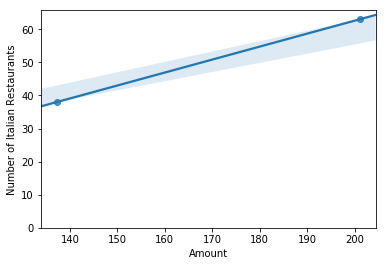

In [185]:
# Amount of Italian-Americans as potential predictor variable of the number of Italian restaurants in New Haven
sns.regplot(x="Amount", y="Number of Italian Restaurants", data=df_nh)
plt.ylim(0,)

As the number of Italian-Americans population goes up, the number of Italian restaurants increases: this indicates a positive direct correlation between these two variables. 